In [1]:
import torch
import numpy as np
import cv2
from model import Model
import matplotlib.pyplot as plt
from art.estimators.classification import PyTorchClassifier
from art.attacks.inference.model_inversion.mi_face import MIFace


/Users/kiwi/projects/ctf/ictf/linear_labyrinth/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the trained model
model = Model()
model.load_state_dict(torch.load('model.pth'))
model.eval()

/var/folders/cf/hc5w25h10pd_8lg71nvgw71m0000gn/T/ipykernel_33654/821160156.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))

Model(
  (linear1): Linear(in_features=133, out_features=133, bias=True)
  (linear2): Linear(in_features=133, out_features=133, bias=True)
)

In [3]:
# Read in out.png
out_img = cv2.imread('out.png', cv2.IMREAD_GRAYSCALE).astype(np.float32)
out_img_tensor = torch.tensor(out_img, dtype=torch.float32)


In [4]:
# Start with a an "average" image: a value of 0.5 in all pixels
# input_img = nn.Parameter(torch.ones(17,133)*.5)
input_img = torch.randn_like(out_img_tensor, dtype=torch.float32, requires_grad=True)

# Start with a random image
# input_img = nn.Parameter(torch.rand(17,133))

optimizer = torch.optim.SGD([input_img], lr=0.01, momentum=0.9)

# Adadelta requires less tuning of the learning rate
# optimizer = torch.optim.Adadelta([input_img], lr=1.0, rho=0.95, eps=1e-6)

# Number of iterations for optimization (you can tweak this value)
num_iterations = 200000

# Loss function, picked MSE https://stackoverflow.com/questions/66220672/what-should-be-the-loss-function-for-image-reconstruction-while-using-unet-archi
criterion = torch.nn.MSELoss()


In [ ]:
for step in range(num_iterations):
    # Let's start with a fresh gradient for each iteration
    optimizer.zero_grad()
    
    model_output = model(input_img) # model output from the current input image guess
    
    # MSE between model output and target output
    loss = criterion(model_output, out_img_tensor) + model_output.abs().sum()*0.008
    
    # Backward pass: Compute gradients
    loss.backward()
    
    # Update the input image based on gradients
    optimizer.step()

    # # Clamp the input image to the range [0, 255]
    # input_img.data.clamp_(0, 255)

    # Normalize the input image to the range [0, 255]
    # input_img.data = (input_img - torch.min(input_img)) / (torch.max(input_img) - torch.min(input_img)) * 255

    if step % 10000 == 0:
        print(f"Step {step}, Loss: {loss.item()}")

Step 0, Loss: 2588.589599609375
Step 10000, Loss: 2111.63916015625
Step 20000, Loss: 1843.864501953125
Step 30000, Loss: 1676.7169189453125


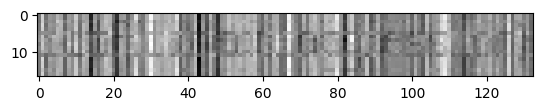

In [ ]:
# After optimization, convert the tensor back to an image
recovered_img = input_img.detach().numpy()

# Normalize the recovered image to the range [0, 255]
recovered_img = (recovered_img - np.min(recovered_img)) / (np.max(recovered_img) - np.min(recovered_img)) * 255

# Convert to uint8 and save the recovered image
recovered_img = recovered_img.astype(np.uint8)
cv2.imwrite('recovered_flag.png', recovered_img)

# Display the recovered image in jupyter notebook

plt.imshow(recovered_img, cmap='gray')

In [ ]:
weight1 = model.linear1.weight  # Shape: [133, 133]
weight2 = model.linear2.weight  # Shape: [133, 133]

In [ ]:
# Print the shape of the image
out_image = cv2.imread('out.png', cv2.IMREAD_GRAYSCALE)  # Load as grayscale (0 means grayscale)
out_tensor = torch.from_numpy(out_image).float()
print(out_tensor.shape)


torch.Size([17, 133])
